## **Exercise 2**

In [ ]:
!pip install transformers[torch] sentence-transformers datasets
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=7153c4b9887975903cad030ee84034485784dfb0a326951daef7ed857fdd1272
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing inst

## **Preprocessing**

In [ ]:
import numpy as np
import requests
import torch
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_recall_curve, auc
from tensorflow.keras.utils import to_categorical


def download_and_read_data(file_url, size):
    response = requests.get(file_url)
    lines = response.text.splitlines()
    sentences = []
    current_sentence = []

    for line in lines:
        if line.startswith('#') or line == '':
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
                if(len(sentences) == size):
                    break
        else:
            parts = line.split('\t')
            if len(parts) > 3:
                current_sentence.append((parts[1], parts[3]))  # (word, pos_tag)
    return sentences if not current_sentence else sentences + [current_sentence]

# URLs
train_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu"
dev_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu"
test_url = f"https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"

# Read and preprocess data
subset_size = 1000
train_data_or = download_and_read_data(train_url, subset_size)
dev_data_or = download_and_read_data(dev_url, int(subset_size/5))
test_data_or = download_and_read_data(test_url, int(subset_size/5))

# Extract words and POS tags
def extract_features(sentence, i):
    word = sentence[i][0]
    pos = sentence[i][1]
    return word, pos

# Create training, development, and test datasets
def create_dataset(data):
    X, y = [], []
    for sentence in data:
        x_s, y_s = [], []
        for i in range(len(sentence)):
            features, pos = extract_features(sentence, i)
            x_s.append(features)
            y_s.append(pos)
        X.append(x_s)
        y.append(y_s)
    return X, y


X_train, y_train = create_dataset(train_data_or)
X_dev, y_dev = create_dataset(dev_data_or)
X_test, y_test = create_dataset(test_data_or)

# Encode POS tags
label_encoder = LabelEncoder()
y_temp = list(chain.from_iterable(y_train))
label_encoder.fit(y_temp)
num_classes = len(label_encoder.classes_)

y_train_encoded = [label_encoder.transform(y_train_part) for y_train_part in y_train]
y_dev_encoded = [label_encoder.transform(y_dev_part) for y_dev_part in y_dev]
y_test_encoded = [label_encoder.transform(y_test_part) for y_test_part in y_test]


# Convert tags to one-hot encoding
y_train_onehot = [to_categorical(y_train_encoded_part, num_classes=num_classes) for y_train_encoded_part in y_train_encoded]
y_dev_onehot = [to_categorical(y_dev_encoded_part, num_classes=num_classes) for y_dev_encoded_part in y_dev_encoded]
y_test_onehot = [to_categorical(y_test_encoded_part, num_classes=num_classes) for y_test_encoded_part in y_test_encoded]

# statistics
print("Training set size:", len(train_data_or))
print("Development set size:", len(dev_data_or))
print("Test set size:", len(test_data_or))
lengths = [len(i) for i in train_data_or] + [len(i) for i in dev_data_or] + [len(i) for i in test_data_or]
print("Average sentence length: ", sum(lengths)/len(lengths))
words_set = set()
for sentences in zip([train_data_or, dev_data_or, test_data_or]):
    for sent in sentences:
        for w in sent:
            words_set.add(w[0])
print("Number of words: ", len(words_set))

Training set size: 1000
Development set size: 200
Test set size: 200
Average sentence length:  21.79
Number of words:  492


## **Tokenization**

In [ ]:
from transformers import AutoTokenizer, DataCollatorForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def align_tokenizations(sentences, taggings):
  bert_tokenized_sentences = []
  aligned_taggings = []

  tokenized_inputs = tokenizer(sentences, truncation=True, is_split_into_words=True)
  labels = []

  for i, label in enumerate(taggings):
      word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
      previous_word_idx = None
      label_ids = []
      for word_idx in word_ids:  # Set the special tokens to -100.
          if word_idx is None:
              label_ids.append(-100)
          elif word_idx != previous_word_idx:  # Only label the first token of a given word.
              label_ids.append(label[word_idx])
          else:
              label_ids.append(-100)
          previous_word_idx = word_idx
      labels.append(label_ids)

  tokenized_inputs["labels"] = labels
  return tokenized_inputs

train_bert_tokenized_sentences = align_tokenizations(X_train, y_train_encoded)
dev_bert_tokenized_sentences = align_tokenizations(X_dev, y_dev_encoded)
test_bert_tokenized_sentences = align_tokenizations(X_test, y_test_encoded)

from torch.utils.data import Dataset

class PosTaggingDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __getitem__(self, i):
    return {'input_ids': self.data['input_ids'][i], 'labels': self.data['labels'][i]}

  def __len__(self):
    return len(self.data['labels'])

train_data = PosTaggingDataset(train_bert_tokenized_sentences)
dev_data = PosTaggingDataset(dev_bert_tokenized_sentences)
test_data = PosTaggingDataset(test_bert_tokenized_sentences)

label2id = {
    'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CCONJ': 4, 'DET': 5, 'INTJ': 6,
    'NOUN': 7, 'NUM': 8, 'PART': 9, 'PRON': 10, 'PROPN': 11, 'PUNCT': 12,
    'SCONJ': 13, 'SYM': 14, 'VERB': 15, 'X': 16, '_': 17,
}

id2label = {
    0: 'ADJ', 1: 'ADP', 2: 'ADV', 3: 'AUX', 4: 'CCONJ', 5: 'DET', 6: 'INTJ',
    7: 'NOUN', 8: 'NUM', 9: 'PART', 10: 'PRON', 11: 'PROPN', 12: 'PUNCT',
    13: 'SCONJ', 14: 'SYM', 15: 'VERB', 16: 'X', 17: '_',
}

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

## **Model and Trainer**

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
from torch import nn


def create_model():
  return AutoModelForTokenClassification.from_pretrained("xlm-roberta-base", id2label=id2label, label2id=label2id)

class CustomTrainer(Trainer):
    """A custom Trainer with class weights for each class.
    """
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # weights 1.0 - (% of 4000), if > 0.9 weight-> 1.5 and if > 0.95 weight -> 2.0
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.594, 0.435, 0.755, 0.702, 0.835, 0.515, 2.0, 0.127, 1.5, 0.856, 0.687, 0.422, 0.362, 0.895, 2.0, 0.452, 2.0, 1.5], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(p):
    """Function to calculate evaluation accuracy during training
    """
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=2)

    predictions_flat = predictions.flatten()
    labels_flat = labels.flatten()

    mask = labels_flat != -100
    accuracy = accuracy_score(labels_flat[mask], predictions_flat[mask])

    return {"accuracy": accuracy}

def create_trainer(model, dropout_rate, lr, epochs, disable_tqdm, load_best_model_at_end):
  """Function to create a CustomTrainer for given model.

    Parameters
    ----------
    model : PreTrainedModel or torch.nn.Module
        The model to train.
    dropout_rate : float
        The weight decay for Adam optimizer.
    lr : float
        The learning rate for Adam optimizer.
    epocjs : int
        The number of epochs to train the model.
    disable_tqdm : bool
        Disables tqdm during training (logs will be printed).
    load_best_model_at_end : bool
        Whether or not to load the best model at the end of training.

    Returns
    -------
    CustomTrainer
  """

  training_args = TrainingArguments(
      output_dir='./tuning/'+str(dropout_rate)+'_'+str(lr)+'_'+str(epochs)+'/',
      overwrite_output_dir=True,
      learning_rate=lr,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      num_train_epochs=epochs,
      weight_decay=dropout_rate,
      logging_steps=63,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      save_total_limit=1,
      load_best_model_at_end=load_best_model_at_end,
      disable_tqdm=disable_tqdm,
  )

  trainer = CustomTrainer(
      model,
      training_args,
      train_dataset=train_data,
      eval_dataset=dev_data,
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
  )

  return trainer

## **Find best hyperparameters**

In [ ]:
import gc

def evaluate_model(dropout_rate, lr, epochs):
  model = create_model()
  trainer = create_trainer(model, dropout_rate, lr, epochs, True, False)

  trainer.train()
  history = trainer.evaluate()

  del model, trainer
  gc.collect()
  torch.cuda.empty_cache()
  return history['eval_accuracy'], history['eval_loss']

def tune_hyperparam(params):
  best_acc = 0
  best_loss = 100
  best_params = ()

  for dro in params["dropout_rate"]:
    for lr in params["learning_rate"]:
      for ep in params["epochs"]:
          print("\nDev accuracy for params: ", (dro, lr, ep))
          acc, loss = evaluate_model(dro, lr, ep)
          if loss < best_loss or (loss == best_loss and acc > best_acc):
            best_acc = acc
            best_loss = loss
            best_params = (dro, lr, ep)

  return best_acc, best_loss, best_params

In [ ]:
hyper_parameters = {
    "dropout_rate": [0.2, 0.4, 0.6],
    "learning_rate": [0.00001, 0.0001, 0.001],
    "epochs": [10],
}

print(tune_hyperparam(hyper_parameters))


Dev accuracy for params:  (0.2, 1e-05, 10)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 2.2675, 'learning_rate': 9e-06, 'epoch': 1.0}
{'eval_loss': 1.320918321609497, 'eval_accuracy': 0.6992129857353665, 'eval_runtime': 0.6901, 'eval_samples_per_second': 289.818, 'eval_steps_per_second': 18.838, 'epoch': 1.0}
{'loss': 0.9119, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.4615035951137543, 'eval_accuracy': 0.9158878504672897, 'eval_runtime': 0.7022, 'eval_samples_per_second': 284.834, 'eval_steps_per_second': 18.514, 'epoch': 2.0}
{'loss': 0.3951, 'learning_rate': 7e-06, 'epoch': 3.0}
{'eval_loss': 0.2741585969924927, 'eval_accuracy': 0.9466305951795376, 'eval_runtime': 0.7499, 'eval_samples_per_second': 266.688, 'eval_steps_per_second': 17.335, 'epoch': 3.0}
{'loss': 0.2426, 'learning_rate': 6e-06, 'epoch': 4.0}
{'eval_loss': 0.2125655710697174, 'eval_accuracy': 0.9576979832759469, 'eval_runtime': 0.7531, 'eval_samples_per_second': 265.579, 'eval_steps_per_second': 17.263, 'epoch': 4.0}
{'loss': 0.1809, 'learning_rate': 5e-06, 'epoch': 5.0

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6658, 'learning_rate': 9e-05, 'epoch': 1.0}
{'eval_loss': 0.18359947204589844, 'eval_accuracy': 0.9589276930644368, 'eval_runtime': 0.7422, 'eval_samples_per_second': 269.471, 'eval_steps_per_second': 17.516, 'epoch': 1.0}
{'loss': 0.1092, 'learning_rate': 8e-05, 'epoch': 2.0}
{'eval_loss': 0.17151571810245514, 'eval_accuracy': 0.9717166748647319, 'eval_runtime': 0.7532, 'eval_samples_per_second': 265.525, 'eval_steps_per_second': 17.259, 'epoch': 2.0}
{'loss': 0.0656, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.17094120383262634, 'eval_accuracy': 0.970486965076242, 'eval_runtime': 0.7365, 'eval_samples_per_second': 271.57, 'eval_steps_per_second': 17.652, 'epoch': 3.0}
{'loss': 0.0389, 'learning_rate': 6e-05, 'epoch': 4.0}
{'eval_loss': 0.1532410830259323, 'eval_accuracy': 0.9790949335956715, 'eval_runtime': 0.7496, 'eval_samples_per_second': 266.795, 'eval_steps_per_second': 17.342, 'epoch': 4.0}
{'loss': 0.0191, 'learning_rate': 5e-05, 'epoch': 5.0}
{'eval_loss'

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 2.7506, 'learning_rate': 0.0009000000000000001, 'epoch': 1.0}
{'eval_loss': 2.715698003768921, 'eval_accuracy': 0.10600098376783079, 'eval_runtime': 0.7217, 'eval_samples_per_second': 277.106, 'eval_steps_per_second': 18.012, 'epoch': 1.0}
{'loss': 2.7272, 'learning_rate': 0.0008, 'epoch': 2.0}
{'eval_loss': 2.7195851802825928, 'eval_accuracy': 0.09099852434825381, 'eval_runtime': 0.7098, 'eval_samples_per_second': 281.769, 'eval_steps_per_second': 18.315, 'epoch': 2.0}
{'loss': 2.7271, 'learning_rate': 0.0007, 'epoch': 3.0}
{'eval_loss': 2.7171151638031006, 'eval_accuracy': 0.09026069847515986, 'eval_runtime': 0.7314, 'eval_samples_per_second': 273.453, 'eval_steps_per_second': 17.774, 'epoch': 3.0}
{'loss': 2.7244, 'learning_rate': 0.0006, 'epoch': 4.0}
{'eval_loss': 2.712956428527832, 'eval_accuracy': 0.09026069847515986, 'eval_runtime': 0.7167, 'eval_samples_per_second': 279.054, 'eval_steps_per_second': 18.139, 'epoch': 4.0}
{'loss': 2.7247, 'learning_rate': 0.0005, 'epoc

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 2.2129, 'learning_rate': 9e-06, 'epoch': 1.0}
{'eval_loss': 1.2082408666610718, 'eval_accuracy': 0.7235612395474668, 'eval_runtime': 0.7381, 'eval_samples_per_second': 270.982, 'eval_steps_per_second': 17.614, 'epoch': 1.0}
{'loss': 0.8251, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.4406355917453766, 'eval_accuracy': 0.9252336448598131, 'eval_runtime': 0.7364, 'eval_samples_per_second': 271.574, 'eval_steps_per_second': 17.652, 'epoch': 2.0}
{'loss': 0.3745, 'learning_rate': 7e-06, 'epoch': 3.0}
{'eval_loss': 0.27415379881858826, 'eval_accuracy': 0.9451549434333497, 'eval_runtime': 0.7341, 'eval_samples_per_second': 272.446, 'eval_steps_per_second': 17.709, 'epoch': 3.0}
{'loss': 0.2368, 'learning_rate': 6e-06, 'epoch': 4.0}
{'eval_loss': 0.2139224261045456, 'eval_accuracy': 0.9591736350221348, 'eval_runtime': 0.7498, 'eval_samples_per_second': 266.749, 'eval_steps_per_second': 17.339, 'epoch': 4.0}
{'loss': 0.1806, 'learning_rate': 5e-06, 'epoch': 5

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6599, 'learning_rate': 9e-05, 'epoch': 1.0}
{'eval_loss': 0.1777026355266571, 'eval_accuracy': 0.9621249385145105, 'eval_runtime': 0.7462, 'eval_samples_per_second': 268.023, 'eval_steps_per_second': 17.422, 'epoch': 1.0}
{'loss': 0.1054, 'learning_rate': 8e-05, 'epoch': 2.0}
{'eval_loss': 0.15904639661312103, 'eval_accuracy': 0.9692572552877521, 'eval_runtime': 0.7594, 'eval_samples_per_second': 263.383, 'eval_steps_per_second': 17.12, 'epoch': 2.0}
{'loss': 0.054, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.16923026740550995, 'eval_accuracy': 0.9756517461878996, 'eval_runtime': 0.752, 'eval_samples_per_second': 265.963, 'eval_steps_per_second': 17.288, 'epoch': 3.0}
{'loss': 0.0389, 'learning_rate': 6e-05, 'epoch': 4.0}
{'eval_loss': 0.1494983732700348, 'eval_accuracy': 0.9786030496802754, 'eval_runtime': 0.7557, 'eval_samples_per_second': 264.669, 'eval_steps_per_second': 17.203, 'epoch': 4.0}
{'loss': 0.023, 'learning_rate': 5e-05, 'epoch': 5.0}
{'eval_loss': 0

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 2.7537, 'learning_rate': 0.0009000000000000001, 'epoch': 1.0}
{'eval_loss': 2.7150588035583496, 'eval_accuracy': 0.0927201180521397, 'eval_runtime': 0.7167, 'eval_samples_per_second': 279.057, 'eval_steps_per_second': 18.139, 'epoch': 1.0}
{'loss': 2.7261, 'learning_rate': 0.0008, 'epoch': 2.0}
{'eval_loss': 2.7203667163848877, 'eval_accuracy': 0.09099852434825381, 'eval_runtime': 0.7089, 'eval_samples_per_second': 282.145, 'eval_steps_per_second': 18.339, 'epoch': 2.0}
{'loss': 2.7262, 'learning_rate': 0.0007, 'epoch': 3.0}
{'eval_loss': 2.716801166534424, 'eval_accuracy': 0.09026069847515986, 'eval_runtime': 0.7194, 'eval_samples_per_second': 278.01, 'eval_steps_per_second': 18.071, 'epoch': 3.0}
{'loss': 2.7237, 'learning_rate': 0.0006, 'epoch': 4.0}
{'eval_loss': 2.7130258083343506, 'eval_accuracy': 0.09026069847515986, 'eval_runtime': 0.7169, 'eval_samples_per_second': 278.992, 'eval_steps_per_second': 18.134, 'epoch': 4.0}
{'loss': 2.7239, 'learning_rate': 0.0005, 'epoch

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 2.213, 'learning_rate': 9e-06, 'epoch': 1.0}
{'eval_loss': 1.2089439630508423, 'eval_accuracy': 0.7233152975897689, 'eval_runtime': 0.7394, 'eval_samples_per_second': 270.504, 'eval_steps_per_second': 17.583, 'epoch': 1.0}
{'loss': 0.824, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.43701252341270447, 'eval_accuracy': 0.9249877029021151, 'eval_runtime': 0.7551, 'eval_samples_per_second': 264.881, 'eval_steps_per_second': 17.217, 'epoch': 2.0}
{'loss': 0.3723, 'learning_rate': 7e-06, 'epoch': 3.0}
{'eval_loss': 0.2707655727863312, 'eval_accuracy': 0.9466305951795376, 'eval_runtime': 0.7392, 'eval_samples_per_second': 270.557, 'eval_steps_per_second': 17.586, 'epoch': 3.0}
{'loss': 0.2345, 'learning_rate': 6e-06, 'epoch': 4.0}
{'eval_loss': 0.21278469264507294, 'eval_accuracy': 0.9576979832759469, 'eval_runtime': 0.747, 'eval_samples_per_second': 267.734, 'eval_steps_per_second': 17.403, 'epoch': 4.0}
{'loss': 0.1801, 'learning_rate': 5e-06, 'epoch': 5.0

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.66, 'learning_rate': 9e-05, 'epoch': 1.0}
{'eval_loss': 0.1711348593235016, 'eval_accuracy': 0.9687653713723561, 'eval_runtime': 0.7457, 'eval_samples_per_second': 268.209, 'eval_steps_per_second': 17.434, 'epoch': 1.0}
{'loss': 0.1054, 'learning_rate': 8e-05, 'epoch': 2.0}
{'eval_loss': 0.1565987467765808, 'eval_accuracy': 0.9763895720609936, 'eval_runtime': 0.7631, 'eval_samples_per_second': 262.087, 'eval_steps_per_second': 17.036, 'epoch': 2.0}
{'loss': 0.0527, 'learning_rate': 7e-05, 'epoch': 3.0}
{'eval_loss': 0.1426609754562378, 'eval_accuracy': 0.9751598622725037, 'eval_runtime': 0.7553, 'eval_samples_per_second': 264.803, 'eval_steps_per_second': 17.212, 'epoch': 3.0}
{'loss': 0.0315, 'learning_rate': 6e-05, 'epoch': 4.0}
{'eval_loss': 0.1603851318359375, 'eval_accuracy': 0.9749139203148057, 'eval_runtime': 0.7528, 'eval_samples_per_second': 265.664, 'eval_steps_per_second': 17.268, 'epoch': 4.0}
{'loss': 0.032, 'learning_rate': 5e-05, 'epoch': 5.0}
{'eval_loss': 0.

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Dev accuracy for params:  (0.6, 0.001, 10)
{'loss': 2.75, 'learning_rate': 0.0009000000000000001, 'epoch': 1.0}
{'eval_loss': 2.7178544998168945, 'eval_accuracy': 0.0927201180521397, 'eval_runtime': 0.7154, 'eval_samples_per_second': 279.564, 'eval_steps_per_second': 18.172, 'epoch': 1.0}
{'loss': 2.7267, 'learning_rate': 0.0008, 'epoch': 2.0}
{'eval_loss': 2.7191333770751953, 'eval_accuracy': 0.09099852434825381, 'eval_runtime': 0.7204, 'eval_samples_per_second': 277.632, 'eval_steps_per_second': 18.046, 'epoch': 2.0}
{'loss': 2.7266, 'learning_rate': 0.0007, 'epoch': 3.0}
{'eval_loss': 2.7164220809936523, 'eval_accuracy': 0.09026069847515986, 'eval_runtime': 0.725, 'eval_samples_per_second': 275.864, 'eval_steps_per_second': 17.931, 'epoch': 3.0}
{'loss': 2.7236, 'learning_rate': 0.0006, 'epoch': 4.0}
{'eval_loss': 2.711369037628174, 'eval_accuracy': 0.09026069847515986, 'eval_runtime': 0.7217, 'eval_samples_per_second': 277.133, 'eval_steps_per_second': 18.014, 'epoch': 4.0}
{'loss

## **Best Model**

In [ ]:
model = create_model()
trainer = create_trainer(model, 0.2, 0.00001, 20, False, True)

trainer.train()
trainer.evaluate()

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.240400,1.256768,0.717413
2,0.829700,0.421609,0.920561
3,0.347500,0.247332,0.953763
4,0.204500,0.199685,0.961879
5,0.150000,0.182459,0.971471
6,0.110800,0.173406,0.973192
7,0.090500,0.169471,0.972455
8,0.073600,0.164504,0.975160
9,0.062500,0.158268,0.975652
10,0.051300,0.155884,0.976881


{'eval_loss': 0.15436944365501404,
 'eval_accuracy': 0.9771273979340875,
 'eval_runtime': 0.7601,
 'eval_samples_per_second': 263.114,
 'eval_steps_per_second': 17.102,
 'epoch': 20.0}

Min validation loss at epoch:  11 -> 0.15436944365501404


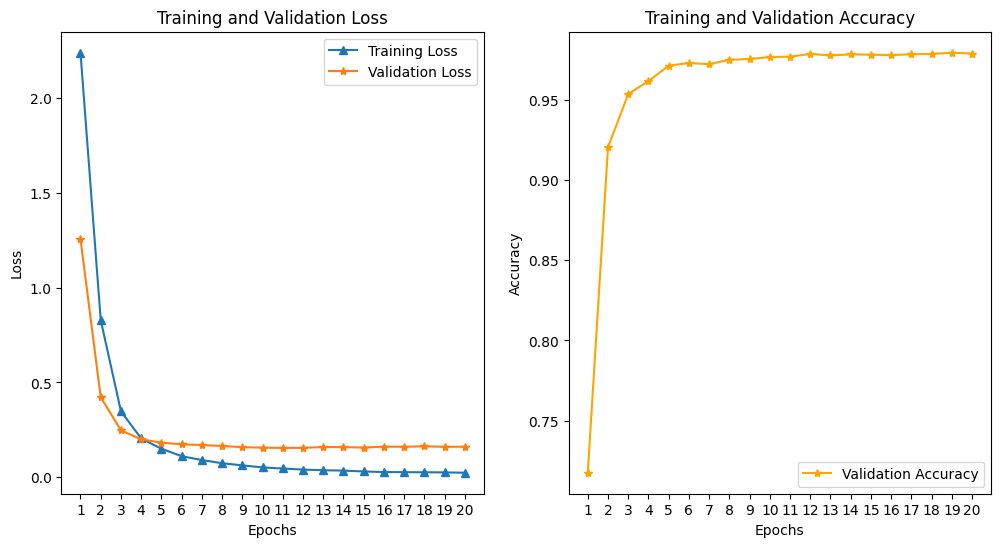

In [ ]:
train_loss, val_loss, val_accuracy = [], [], []
history = trainer.state.log_history

for log in range(len(history)-2):
  if log%2 == 0:
    train_loss.append(history[log]['loss'])
  else:
    val_loss.append(history[log]['eval_loss'])
    val_accuracy.append(history[log]['eval_accuracy'])

print("Min validation loss at epoch: ", val_loss.index(min(val_loss))+1, "->", min(val_loss))

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, '-^', label='Training Loss')
plt.plot(val_loss, '-*', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(len(train_loss)), np.arange(1, len(train_loss)+1))
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(val_accuracy, '-*', label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(len(train_loss)), np.arange(1, len(train_loss)+1))
plt.legend()
plt.show()

## **Metrics**

In [ ]:
def my_predict(data):
  sample = [" ".join(x) for x in data]

  tokenized_sample = tokenizer(sample, truncation=True, padding=True,
                              return_tensors='pt').to("cuda:0")
  model.eval()
  with torch.no_grad():
    predictions = model(**tokenized_sample)

  tags = [[ti.item() for ti in t ] for t in predictions.logits.argmax(-1)]
  y_pred_class = []
  for k in range(len(tags)):
    a = tokenized_sample.word_ids(batch_index=k)
    result = []
    last_i=None
    for i in a:
      if i==None:
        continue
      elif i != last_i:
        result.append(tags[k][a.index(i)])
        last_i = i

    y_pred_class.append(to_categorical(result, num_classes=num_classes))

  return y_pred_class


def calculate_metrics(custom_model, X, y):
  y_pred_class = np.array(list(chain.from_iterable(my_predict(X))))
  y = np.array(list(chain.from_iterable(y)))
  report = classification_report(y, y_pred_class, output_dict=True)
  n_classes = num_classes

  # For each class
  for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y[:, i], y_pred_class[:, i])
    try:
      report[str(i)]["pr-auc"] = auc(recall, precision)
    except:
      report[str(i)] = {"precision": 0, "recall": 0, "f1-score": 0, "pr-auc": auc(recall, precision), "support": 0}

  # A "macro-average": quantifying score on all classes jointly
  precision, recall, _ = precision_recall_curve(y.ravel(), y_pred_class.ravel())
  report["macro avg"]["pr-auc"] = auc(recall, precision)
  report["accuracy"] = {"precision": '', "recall": '', "f1-score": accuracy_score(y, y_pred_class), "pr-auc": '', "support": report["macro avg"]["support"]}
  del report["weighted avg"]

  pd.set_option('display.precision', 4)
  final_report = pd.DataFrame.from_dict(report).T
  final_report["support"] = final_report["support"].astype(int)
  final_report = final_report.reindex(columns=["precision", "recall", "f1-score", "pr-auc", "support"])
  return final_report


for name, X_set, y_set in zip(["Training", "Development", "Test"],
                              [X_train, X_dev, X_test],
                              [y_train_onehot, y_dev_onehot, y_test_onehot]):
  print("\nMetrics for", name, "dataset:")
  print(calculate_metrics(model, X_set, y_set))


Metrics for Training dataset:
            precision  recall f1-score  pr-auc  support
0              0.9854  0.9963   0.9908   0.991     1626
1              0.9982  0.9969   0.9976  0.9977     2259
2              0.9869  0.9969   0.9919   0.992      979
3                 1.0     1.0      1.0     1.0     1193
4              0.9985  0.9985   0.9985  0.9985      660
5              0.9995   0.999   0.9992  0.9993     1942
6                 1.0   0.963   0.9811  0.9815       27
7              0.9959  0.9757   0.9857  0.9877     3491
8              0.9812     1.0   0.9905  0.9906      313
9                 1.0     1.0      1.0     1.0      576
10             0.9968  0.9992    0.998   0.998     1252
11             0.9812  0.9948    0.988  0.9883     2311
12             0.9984     1.0   0.9992  0.9992     2551
13             0.9882     1.0   0.9941  0.9941      420
14                1.0  0.7895   0.8824  0.8948       19
15             0.9946  0.9986   0.9966  0.9967     2193
16               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            precision  recall f1-score  pr-auc  support
0              0.9477  0.9544    0.951  0.9527      285
1              0.9841  0.9841   0.9841  0.9848      377
2              0.9467  0.9524   0.9496  0.9505      168
3              0.9957  0.9957   0.9957  0.9959      235
4                 1.0    0.98   0.9899  0.9902      100
5              0.9919  0.9946   0.9933  0.9935      370
6                 0.0     0.0      0.0  0.0001        1
7              0.9708  0.9599   0.9654  0.9685      624
8              0.9811     1.0   0.9905  0.9906       52
9                 1.0  0.9904   0.9952  0.9953      104
10             0.9964  0.9964   0.9964  0.9966      280
11             0.9624  0.9755   0.9689    0.97      367
12             0.9961     1.0   0.9981  0.9981      514
13             0.9326  0.9881   0.9595  0.9605       84
14                1.0     0.6     0.75  0.8002        5
15             0.9767  0.9745   0.9756   0.977      431
16                0.0     0.0      0.0  0.5012  